# Assignment - Advanced Regression

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

%matplotlib inline

#### basic checks on the dataset

In [3]:
house_price = pd.read_csv('train.csv')

In [4]:
house_price.shape

(1460, 81)

In [5]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Checking the dataset for nulls 

In [12]:
round(house_price.isnull().sum()/len(house_price.index),2).sort_values(ascending=False).head(20)

PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
GarageCond      0.06
BsmtExposure    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtFinType2    0.03
BsmtFinType1    0.03
MasVnrType      0.01
MasVnrArea      0.01
Id              0.00
Functional      0.00
dtype: float64

#### Considering 10% as threshold and dropping the column having more then the threshold

In [13]:
round(house_price.isnull().sum()/len(house_price.index),2)[round(house_price.isnull().sum()/
                                                                 len(house_price.index),2).values>0.10]

LotFrontage    0.18
Alley          0.94
FireplaceQu    0.47
PoolQC         1.00
Fence          0.81
MiscFeature    0.96
dtype: float64

In [14]:
house_price = house_price.drop(['LotFrontage','Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis='columns')

#### Checking the columns where the missing values between 0-10%

In [15]:
round(house_price.isnull().sum()/len(house_price.index),2)[round(house_price.isnull().sum()/
                                                                 len(house_price.index),2).values>0.00]

MasVnrType      0.01
MasVnrArea      0.01
BsmtQual        0.03
BsmtCond        0.03
BsmtExposure    0.03
BsmtFinType1    0.03
BsmtFinType2    0.03
GarageType      0.06
GarageYrBlt     0.06
GarageFinish    0.06
GarageQual      0.06
GarageCond      0.06
dtype: float64

#### Before going further we will try to convert the Year columns with the age where we are going to fill these columns with number , And if we query the max year for all these columns these will come out to be 2010 ,EX suppose the YearBuilt=2000 , Then YearBuiltOld = 2010-2000 =10

In [16]:
house_price['YearBuilt_Old'] = house_price.YearBuilt.max()-house_price.YearBuilt
house_price['YearRemodAdd_Old'] = house_price.YearRemodAdd.max()-house_price.YearRemodAdd
house_price['GarageYrBlt_Old'] = house_price.GarageYrBlt.max()-house_price.GarageYrBlt
house_price['YrSold_Old'] = house_price.YrSold.max()-house_price.YrSold
house_price[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_Old','YearRemodAdd_Old',
             'GarageYrBlt_Old','YrSold_Old']].sample(10)

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
329,1920,1950,1920.0,2009,90,60,90.0,1
1396,1948,1950,1966.0,2010,62,60,44.0,0
617,1954,1954,1962.0,2008,56,56,48.0,2
210,1925,1950,NaN,2008,85,60,NaN,2
1309,1991,1991,1991.0,2008,19,19,19.0,2
1289,2006,2006,2006.0,2006,4,4,4.0,4
167,2007,2007,2007.0,2007,3,3,3.0,3
697,1952,1952,1952.0,2006,58,58,58.0,4
252,2004,2004,2004.0,2008,6,6,6.0,2
984,1977,1977,1977.0,2009,33,33,33.0,1


#### Dropping the actual Year columns


In [17]:
house_price = house_price.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis='columns')

#### Impute missing value

In [18]:
house_price.MasVnrType.fillna('None',inplace=True)
house_price.MasVnrArea.fillna(house_price.MasVnrArea.mean(),inplace=True)
house_price.BsmtQual.fillna('TA',inplace=True)
house_price.BsmtCond.fillna('TA',inplace=True)
house_price.BsmtExposure.fillna('No',inplace=True)
house_price.BsmtFinType1.fillna('Unf',inplace=True)
house_price.BsmtFinType2.fillna('Unf',inplace=True)
house_price.GarageType.fillna('Attchd',inplace=True)
house_price.GarageYrBlt_Old.fillna(-1,inplace=True)
house_price.GarageFinish.fillna('Unf',inplace=True)
house_price.GarageQual.fillna('TA',inplace=True)
house_price.GarageCond.fillna('TA',inplace=True)

#### As per the analysis 'Street' & 'Utilities' is explaining the lowest valrience hence dropping these columns

In [19]:
house_price.Street.value_counts()
house_price.Utilities.value_counts()
house_price = house_price.drop(['Street','Utilities'],axis='columns')

#### 'Id' column is not useful for our analysis, dropping the column

In [20]:
house_price = house_price.drop('Id',axis='columns')

In [21]:
house_price[list(house_price.dtypes[house_price.dtypes!='object'].index)].describe()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890,38.732192,25.134247,29.691096,2.184247
std,42.300571,9981.264932,1.382997,1.112799,180.569112,456.098091,161.319273,441.866955,438.705324,386.587738,...,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883,30.202904,20.645407,25.121824,1.328095
min,20.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,0.000000,0.000000,-1.000000,0.000000
25%,20.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000,10.000000,6.000000,7.000000,1.000000
50%,50.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000,37.000000,16.000000,25.500000,2.000000
75%,70.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000,56.000000,43.000000,48.000000,3.000000
max,190.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000,138.000000,60.000000,110.000000,4.000000


#### Lets plot some graph for EDA 

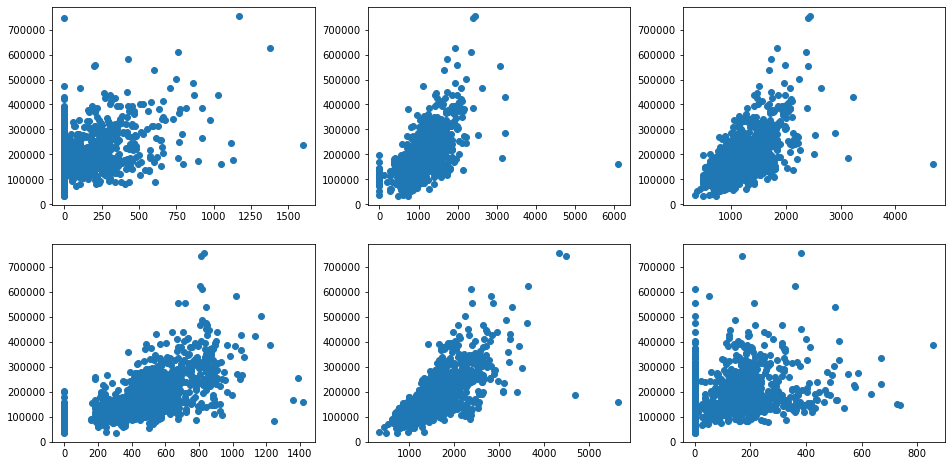

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.scatter(house_price.MasVnrArea,house_price.SalePrice)
plt.subplot(2,3,2)
plt.scatter(house_price.TotalBsmtSF,house_price.SalePrice)
plt.subplot(2,3,3)
plt.scatter(house_price['1stFlrSF'],house_price.SalePrice)
plt.subplot(2,3,4)
plt.scatter(house_price['GarageArea'],house_price.SalePrice)
plt.subplot(2,3,5)
plt.scatter(house_price['GrLivArea'],house_price.SalePrice)
plt.subplot(2,3,6)
plt.scatter(house_price['WoodDeckSF'],house_price.SalePrice)

#### Plotting heatmap to check the corellation between variables

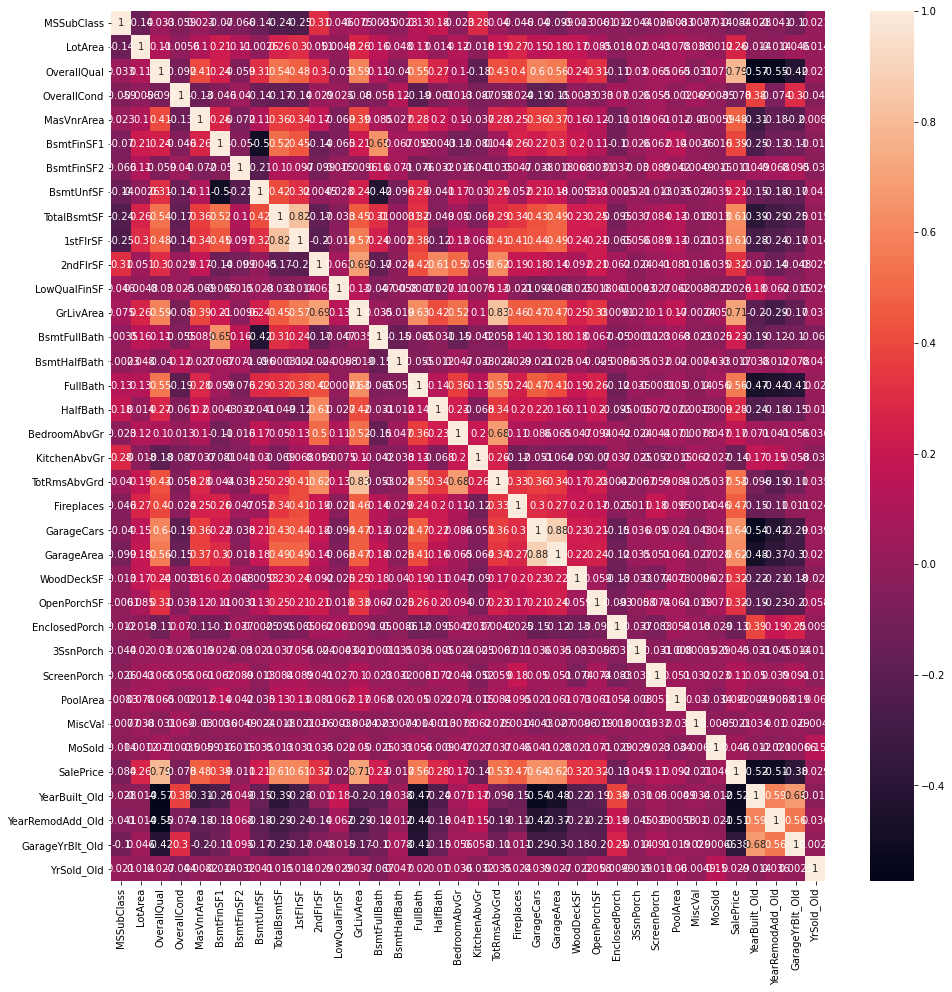

In [23]:
plt.figure(figsize=(16,16))
sns.heatmap(house_price[list(house_price.dtypes[house_price.dtypes!='object'].index)].corr(),annot=True)
plt.show()

### This function is for handling outliers, taking the lower and upper quantile as 0.25 & 0.99 respectively

In [24]:
house_price.shape

(1460, 72)

In [25]:
num_col = list(house_price.dtypes[house_price.dtypes !='object'].index)
num_col = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
           'EnclosedPorch','3SsnPorch',
           'ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
def drop_outliers(x):
    list = []
    for col in num_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

house_price = drop_outliers(house_price)

In [26]:
house_price.shape

(1441, 72)

In [27]:
house_price[list(house_price.dtypes[house_price.dtypes=='object'].index)].head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


#### Lets check for the below columns here we can clearly see that these are having some kind of order and hence we can say these are ordinal in nature

In [28]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1


In [29]:
house_price['LandSlope'] = house_price.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
house_price['ExterQual'] = house_price.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['BsmtQual'] = house_price.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtCond'] = house_price.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtExposure'] = house_price.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
house_price['BsmtFinType1'] = house_price.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['BsmtFinType2'] = house_price.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['HeatingQC'] = house_price.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['CentralAir'] = house_price.CentralAir.map({'N':0,'Y':1})
house_price['KitchenQual'] = house_price.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['GarageFinish'] = house_price.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
house_price['GarageQual'] = house_price.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['GarageCond'] = house_price.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['ExterCond'] = house_price.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['LotShape'] = house_price.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

#### Lets take a look into the converted columns

In [30]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


#### Creating and joining dummy column with the actual dataset

In [31]:
dummy_col = pd.get_dummies(house_price[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],
                           drop_first=True)

house_price = pd.concat([house_price,dummy_col],axis='columns')

house_price = house_price.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

#### Let us check the distribution of our target variable before scaling and Splitting

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


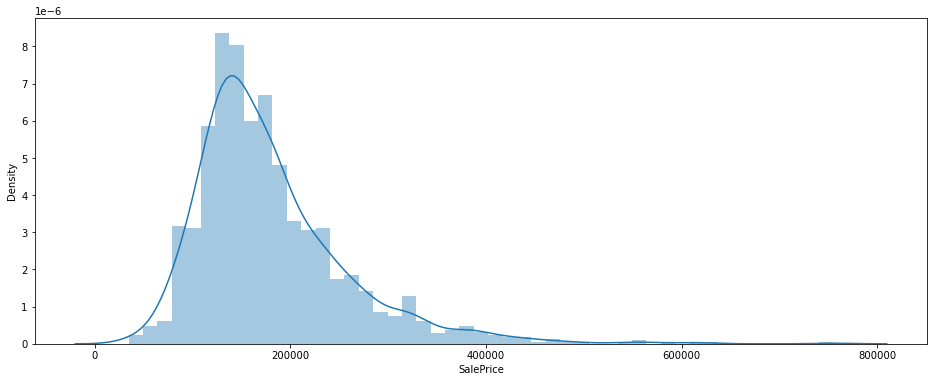

In [32]:
plt.figure(figsize=(16,6))
sns.distplot(house_price.SalePrice)
plt.show()

#### Creating train and test dataset for validation purpose

In [33]:
df_train,df_test = train_test_split(house_price,train_size=0.75,test_size=0.25,random_state=42)

In [34]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


#### Scaling the train dataset

In [35]:
num_col = ['MSSubClass','LotArea','OverallQual','OverallCond',
           'MasVnrArea','BsmtFinSF1',
           'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
           'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
           'ScreenPorch','PoolArea','MiscVal','SalePrice']

scaler = StandardScaler()
df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_test[num_col] = scaler.transform(df_test[num_col])

<ipython-input-35-35543c885d03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[num_col] = scaler.fit_transform(df_train[num_col])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-35-35543c885d03>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

#### Lets check the distribution again after scaling

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

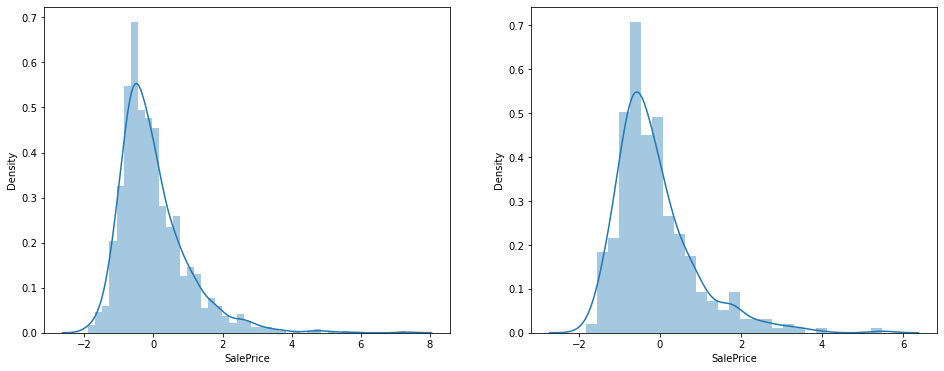

In [36]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(df_train.SalePrice)
plt.subplot(122)
sns.distplot(df_test.SalePrice)

#### Spliting the dependent and independent variable

In [37]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [38]:
y_test = df_test.pop('SalePrice')
X_test = df_test

#### Now using  RFE  lets try to to find the optimal number of feature

In [39]:
len(X_train.columns)

193

In [40]:
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=70 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


RFE(estimator=LinearRegression(), n_features_to_select=70)

In [41]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [42]:
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

#### Lets filter the train and test set for the RFE selected columns

In [43]:
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

## Lasso regression model

In [44]:
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8821543120464249
0.8705415935815151


In [45]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

[('MSSubClass', -1.312),
 ('LotArea', 0.229),
 ('LotShape', 0.168),
 ('LandSlope', 0.147),
 ('OverallQual', 0.03),
 ('OverallCond', -0.0),
 ('MasVnrArea', 0.092),
 ('ExterQual', 0.006),
 ('ExterCond', 0.0),
 ('BsmtQual', -0.021),
 ('BsmtCond', 0.383),
 ('BsmtExposure', 0.187),
 ('BsmtFinType1', 0.031),
 ('BsmtFinSF1', -0.0),
 ('BsmtFinType2', 0.091),
 ('BsmtFinSF2', -0.0),
 ('BsmtUnfSF', 0.156),
 ('TotalBsmtSF', -0.023),
 ('HeatingQC', -0.013),
 ('CentralAir', -0.142),
 ('1stFlrSF', -0.197),
 ('2ndFlrSF', -0.146),
 ('LowQualFinSF', -0.131),
 ('GrLivArea', -0.0),
 ('BsmtFullBath', -0.195),
 ('BsmtHalfBath', -0.164),
 ('FullBath', -0.194),
 ('HalfBath', 0.37),
 ('BedroomAbvGr', -0.176),
 ('KitchenAbvGr', -0.288),
 ('KitchenQual', -0.083),
 ('TotRmsAbvGrd', -0.227),
 ('Fireplaces', 0.0),
 ('GarageFinish', 0.276),
 ('GarageCars', -0.064),
 ('GarageArea', -0.0),
 ('GarageQual', -0.299),
 ('GarageCond', -0.086),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', -1.739),
 ('EnclosedPorch', -0.253),
 ('3

#### Now lets try to improve our model with the optimal value of alpha using GridSearchCV

In [46]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [47]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.057494,0.005990,0.006065,0.003272,0.001,{'alpha': 0.001},0.856657,0.586251,0.865325,0.875052,...,0.880332,0.883268,0.889716,0.878703,0.890560,0.877290,0.882006,0.882391,0.884371,0.005391
1,0.012107,0.003635,0.002615,0.002899,0.010,{'alpha': 0.01},0.818760,0.567416,0.823799,0.855096,...,0.833844,0.830568,0.829214,0.826508,0.839703,0.825972,0.832382,0.829263,0.833846,0.008738
2,0.007668,0.000890,0.003233,0.003960,0.100,{'alpha': 0.1},0.757765,0.636863,0.766288,0.796357,...,0.780736,0.784227,0.778673,0.778268,0.788566,0.775783,0.784583,0.780717,0.784533,0.008679
3,0.006467,0.003405,0.002353,0.002871,1.000,{'alpha': 1.0},-0.001945,-0.000041,-0.000772,-0.000776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.007624,0.003105,0.001732,0.003216,5.000,{'alpha': 5.0},-0.001945,-0.000041,-0.000772,-0.000776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


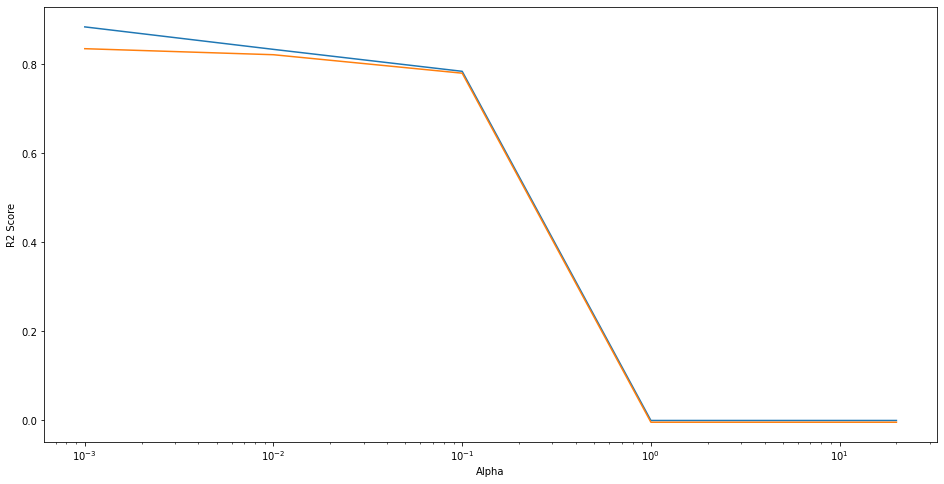

In [48]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [49]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 0.001}

In [50]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8821543120464249
0.8705415935815151


In [51]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featuere','Coef']

In [52]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featuere,Coef
49,YrSold_Old,1.045266
10,BsmtCond,0.382601
27,HalfBath,0.369919
67,Neighborhood_Edwards,0.296615
33,GarageFinish,0.275556
60,LotConfig_Inside,0.233129
1,LotArea,0.228636
64,Neighborhood_ClearCr,0.219746
11,BsmtExposure,0.187104
2,LotShape,0.167537


## Ridge regression model

In [53]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.8917427790868349
0.8607427677382186


In [54]:
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [55]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.009342,0.003433,0.004624,0.003794,0.001,{'alpha': 0.001},0.863570,0.620507,0.884602,0.846521,...,0.890287,0.891792,0.899370,0.888117,0.901098,0.887728,0.890530,0.891519,0.893810,0.005352
1,0.008261,0.001323,0.005391,0.003140,0.010,{'alpha': 0.01},0.863534,0.620673,0.884521,0.847077,...,0.890286,0.891791,0.899367,0.888116,0.901097,0.887727,0.890529,0.891518,0.893809,0.005352
2,0.007465,0.000851,0.005340,0.003968,0.100,{'alpha': 0.1},0.863180,0.622230,0.883718,0.851375,...,0.890199,0.891702,0.899112,0.888037,0.901004,0.887636,0.890451,0.891433,0.893709,0.005336
3,0.010618,0.009853,0.004058,0.004098,0.200,{'alpha': 0.2},0.862805,0.623731,0.882842,0.854486,...,0.889984,0.891496,0.898526,0.887838,0.900774,0.887410,0.890259,0.891221,0.893465,0.005305
4,0.006311,0.003896,0.003251,0.003494,0.500,{'alpha': 0.5},0.861801,0.626950,0.880340,0.859717,...,0.888984,0.890590,0.896146,0.886885,0.899706,0.886347,0.889356,0.890228,0.892365,0.005215


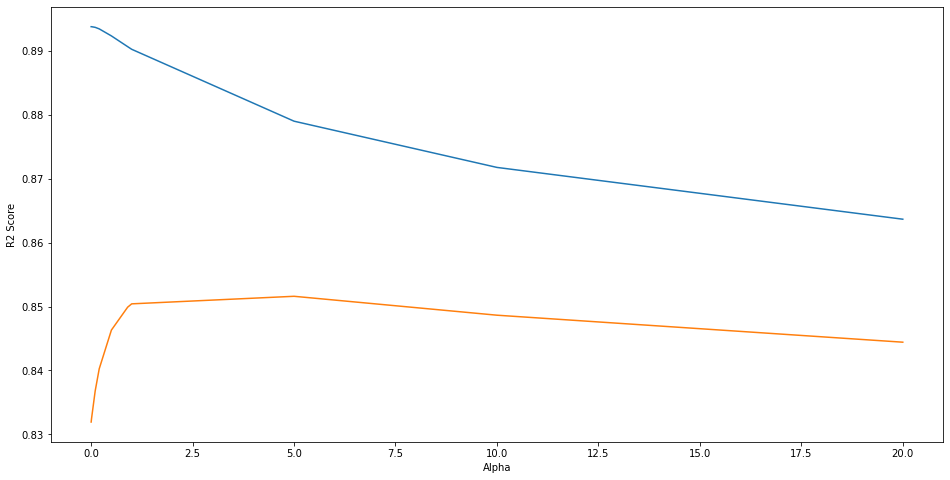

In [56]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
# plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [57]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 5.0}

In [59]:
ridge = Ridge(alpha = 5.0)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.878473955296414
0.8694097920932716


In [60]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feaure','Coef']

In [61]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
49,YrSold_Old,0.641571
27,HalfBath,0.324125
33,GarageFinish,0.251538
67,Neighborhood_Edwards,0.244703
60,LotConfig_Inside,0.223638
1,LotArea,0.223208
64,Neighborhood_ClearCr,0.219305
10,BsmtCond,0.213625
11,BsmtExposure,0.190206
50,MSZoning_FV,0.173940


### After creating model in both Ridge and Lasso we can see that the r2_scores are almost same for both of them but as lasso will penalize more on the dataset and can also help in feature elemination i am goint to consider that as my final model.

## Final Model

In [62]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8821543120464249
0.8705415935815151


#### Best alpha value for Lasso : {'alpha': 0.001}

#### Best alpha value for Ridge : {'alpha': 5.0}